## nc数据 读取与处理
**需要 netCDF4 库**

In [4]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt

# 读取数据
# 路径不要有中文
nf = nc.Dataset(r'C:\Users\Loshawn\Documents\Daiso\SAR-wind\code\Wind_field_inversion\data\data2.nc','r')

In [5]:
# 查看储存变量
keys = nf.variables.keys()  
keys

dict_keys(['longitude', 'latitude', 'time', 'u10', 'v10'])

### 变量解释 
u10 : 10米高的U风分量，东西方向风速，西风为正 →  
v10 : 10米高的V风分量，南北方向风速，南风为正 ↑  
  
按 地图标准方向 建立 XY 坐标系  

数值记录方式：   
- scale_factor : 比例因子  
- add_offset : 偏移值  
- _FillValue : 充填值
- missing_value : 缺失值

实际值 = scale_factor * 存储值 + add_offset  


In [8]:
# 查看变量信息
longitude = nf.variables['longitude']
u10 = nf.variables['u10']
v10 = nf.variables['v10']
time = nf.variables['time'] # units 时间储存格式

u10

<class 'netCDF4._netCDF4.Variable'>
int16 u10(time, latitude, longitude)
    scale_factor: 0.00010985638914745243
    add_offset: -2.6642394985070736
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: 10 metre U wind component
unlimited dimensions: 
current shape = (1, 9, 13)
filling on

In [10]:
# 读取变量值
u10_arr = nf.variables['u10'][:]
v10_arr = nf.variables['v10'][:]
u10_arr

masked_array(
  data=[[[ 1.78624140e-01,  4.78422226e-01,  9.35424805e-01,
           6.87369078e-01,  7.50295649e-02, -8.01844133e-01,
          -1.88689569e+00, -2.87615247e+00, -2.50505759e+00,
          -2.29501217e+00, -3.56945615e+00, -4.94441871e+00,
          -5.58114634e+00],
         [ 2.85391721e-03,  4.72489981e-01,  6.62980960e-01,
           3.73948800e-01, -3.94606499e-01, -1.15931682e+00,
          -2.58316548e+00, -3.43663977e+00, -3.30382340e+00,
          -3.96493915e+00, -5.24136053e+00, -5.73835084e+00,
          -6.26379395e+00],
         [-3.66373407e-01, -1.98402988e-01, -1.14362850e-01,
          -3.70218380e-01, -1.13877368e+00, -2.19449358e+00,
          -3.64954145e+00, -4.47082782e+00, -4.93376264e+00,
          -5.45228480e+00, -5.80964763e+00, -5.90049887e+00,
          -6.06165819e+00],
         [-8.08765086e-01, -6.59250540e-01, -6.46617055e-01,
          -9.05438708e-01, -1.40440643e+00, -2.25304703e+00,
          -3.08213320e+00, -3.80092356e+00, -4.3

In [11]:
# 时间转化
time_arr = nf.variables['time'][:]
time = nc.num2date(time_arr, time.units) # 按照 time.units 储存格式来 格式化时间
time

masked_array(data=[cftime.DatetimeGregorian(2024, 2, 4, 10, 0, 0, 0, has_year_zero=False)],
             mask=False,
       fill_value='?',
            dtype=object)

In [12]:
# 维度查看
lat_shape = nf.variables['latitude'][:].shape
lon_shape = nf.variables['longitude'][:].shape
u10_shape = nf.variables['u10'][:].shape

lat_shape, lon_shape, u10_shape

((9,), (13,), (1, 9, 13))

示例

Text(0.5, 0.92, 'Actual speed')

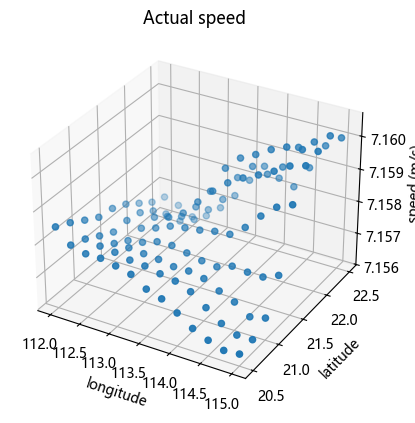

In [14]:
# 示例
# 散点风速

lat = nf.variables['latitude'][:]
lon = nf.variables['longitude'][:]
u = nf.variables['u10']
v = nf.variables['v10']

u = u[:] * u.scale_factor + u.add_offset
v = v[:] * v.scale_factor + v.add_offset

V = u**2 + v**2
lon, lat = np.meshgrid(lon, lat)

ax1 = plt.axes(projection='3d')
ax1.scatter(lon, lat, V)
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
ax1.set_zlabel("speed (m/s)")
ax1.set_title("Actual speed")

Text(0.5, 0.92, 'Speed Fit')

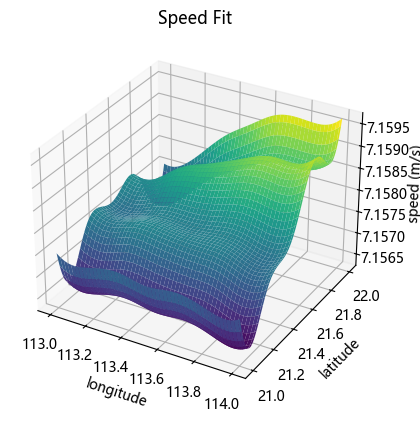

In [15]:
# 风速拟合
from scipy.interpolate import Rbf

lat = nf.variables['latitude'][:]
lon = nf.variables['longitude'][:]
u = nf.variables['u10']
v = nf.variables['v10']

u = u[:] * u.scale_factor + u.add_offset
v = v[:] * v.scale_factor + v.add_offset
lon, lat = np.meshgrid(lon, lat)

V = u ** 2 + v ** 2

# 拟合与插值
rbf = Rbf(lon, lat, V, function='multiquadric')

x = np.linspace(113,114, 100)
y = np.linspace(21,22, 100)
x,y = np.meshgrid(x, y)

v_fit = rbf(x,y)

# 绘图
ax1 = plt.axes(projection='3d')
ax1.plot_surface(x, y, v_fit, cmap='viridis')
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
ax1.set_zlabel("speed (m/s)")
ax1.set_title("Speed Fit")

In [43]:
# 风向拟合
from scipy.interpolate import Rbf

lat = nf.variables['latitude'][:]
lon = nf.variables['longitude'][:]
u = nf.variables['u10']
v = nf.variables['v10']

u = u[:] * u.scale_factor + u.add_offset
v = v[:] * v.scale_factor + v.add_offset
lon, lat = np.meshgrid(lon, lat)

# 拟合
rbf_u = Rbf(lon, lat, u, function='multiquadric')
rbf_v = Rbf(lon, lat, v, function='multiquadric')

# 插值
x = np.linspace(113,114, 100)
y = np.linspace(21,22, 100)

x,y = np.meshgrid(x, y)

u_fit = rbf_u(x,y)
v_fit = rbf_v(x,y)

theta = np.arctan(v_fit,u_fit) # v/u, 与东方向的夹角, 弧度制
theta, theta.shape

(array([[0.23768395, 0.23768192, 0.23767999, ..., 0.23755149, 0.23755054,
         0.23754966],
        [0.23767727, 0.23767528, 0.23767337, ..., 0.23754515, 0.23754425,
         0.23754343],
        [0.23767113, 0.23766917, 0.2376673 , ..., 0.23753917, 0.23753832,
         0.23753755],
        ...,
        [0.23770876, 0.23770773, 0.23770685, ..., 0.23752483, 0.23752291,
         0.23752111],
        [0.23771318, 0.23771218, 0.23771135, ..., 0.23753182, 0.23752987,
         0.23752806],
        [0.23771814, 0.23771717, 0.23771637, ..., 0.23753932, 0.23753735,
         0.23753552]]),
 (100, 100))